In [20]:
import os,time, textwrap, requests, pandas as pd
from pathlib import Path

#Con esto creamos las carpetas donde se guardan los datos originales y los datos procesados
RAW = Path("data/raw");
RAW.mkdir(parents=True, exist_ok=True)

PROC = Path("data/processed");
PROC.mkdir(parents=True, exist_ok=True)

#years = [2019, 2020, 2021]

#ENDPOINTS = ["https://datos.cdmx.gob.mx/explore/dataset/incidentes-viales-c5/download/?format=csv&lang=es&timezone=America/Mexico_City&refine.ano={year}"]

def buscar_año(timeout=120):
    ult_err = None
    #for tpl in ENDPOINTS:
    url = "https://archivo.datos.cdmx.gob.mx/C5/incidentes_viales/inViales_2022_2024.csv" #tpl.format(year = year)
    try:
        r = requests.get(url,timeout=timeout)
        if r.content and r.status_code == 200 and len(r.content) > 1000:
            out = RAW / "c5_incidentes_2022_2024.csv"
            out.write_bytes(r.content)
            print(f"* {out} ({len(r.content)//1024} KB)")
            return out
        else:
            ult_err = f"HTTP {r.status_code}"
    except Exception as e:
        ult_err = str(e)
    time.sleep(1.5)
    raise RuntimeError(f"No se pudo descargar. Último error: {ult_err}")

archivos = []
#for y in years:
try:
    archivos.append(buscar_año())
except Exception as e:
    print(f"[WARN]: {e}")

* data/raw/c5_incidentes_2022_2024.csv (101746 KB)


In [41]:
df = pd.read_csv(archivos[0])

def normalizacion_cols(cols):
    return [c.strip().lower().replace(" ", "_").replace(" ", "_") for c in cols]

df.columns = normalize_cols(df.columns)

print("Filas totales:", len(df))
print("Columnas:", len(df.columns))
df.sample(5).head

Filas totales: 504261
Columnas: 17


<bound method NDFrame.head of                     folio fecha_creacion hora_creacion dia_semana  \
258396  C5/20230211/03590     2023-02-11      18:04:31     Sábado   
493028  C5/20240212/05041     2024-02-12      23:38:13      Lunes   
328095  C5/20230603/03995     2023-06-03      15:16:47     Sábado   
332442  C5/20230609/01900     2023-06-09      18:53:35    Viernes   
218531  C5/20221208/01103     2022-12-08      09:13:57     Jueves   

       fecha_cierre hora_cierre tipo_incidente_c4           incidente_c4  \
258396   2023-02-11    21:06:43         Accidente  Choque sin lesionados   
493028   2024-02-13    03:06:09         Accidente  Choque sin lesionados   
328095   2023-06-03    18:19:16         Accidente  Choque sin lesionados   
332442   2023-06-10    20:00:06         Accidente  Choque sin lesionados   
218531   2022-12-08    12:22:08         Accidente  Choque con lesionados   

          alcaldia_inicio codigo_cierre  clas_con_f_alarma     tipo_entrada  \
258396         IZTA

In [51]:
#Revisa donde hay datos faltantes y el número de duplicados
print(df.isna().sum())
print(f"Duplicados: {df.duplicated().sum()}")

df["fecha_creacion"] = pd.to_datetime(df["fecha_creacion"], errors="coerce")
df["hora_creacion"] = pd.to_datetime(df["hora_creacion"], errors="coerce")

df["anio"] = df["fecha_creacion"].dt.year
df["mes"] = df["fecha_creacion"].dt.month
df["dia_semana"] = df["fecha_creacion"].dt.day_name()
df["hora"] = df["hora_creacion"].dt.hour

df = df[df["anio"].isin([2022, 2023, 2024])]

print(df.head())

folio                    0
fecha_creacion           0
hora_creacion            0
dia_semana               0
fecha_cierre             0
hora_cierre              0
tipo_incidente_c4        0
incidente_c4             0
alcaldia_inicio         34
codigo_cierre            0
clas_con_f_alarma        0
tipo_entrada             5
alcaldia_cierre         34
alcaldia_catalogo      554
colonia_catalogo     11174
longitud                 0
latitud                  0
anio                     0
mes                      0
hora                     0
dtype: int64
Duplicados: 0


/tmp/ipykernel_3276/1234214744.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["hora_creacion"] = pd.to_datetime(df["hora_creacion"], errors="coerce")


                folio fecha_creacion       hora_creacion dia_semana  \
2  C2C/20220101/00012     2022-01-01 2025-08-17 01:06:39   Saturday   
3  C2C/20220101/00070     2022-01-01 2025-08-17 09:51:53   Saturday   
5  C2N/20220101/00057     2022-01-01 2025-08-17 03:33:05   Saturday   
6  C2N/20220101/00101     2022-01-01 2025-08-17 09:56:54   Saturday   
7  C2N/20220101/00160     2022-01-01 2025-08-17 18:10:42   Saturday   

  fecha_cierre hora_cierre tipo_incidente_c4           incidente_c4  \
2   2022-01-01    06:00:12         Accidente  Choque con lesionados   
3   2022-01-01    12:54:10         Accidente           Motociclista   
5   2022-01-01    06:44:09         Accidente  Choque con lesionados   
6   2022-01-01    13:04:08         Accidente  Choque sin lesionados   
7   2022-01-01    21:14:13         Accidente  Choque con lesionados   

       alcaldia_inicio codigo_cierre  clas_con_f_alarma      tipo_entrada  \
2           CUAUHTEMOC             A  URGENCIAS MEDICAS  BOTÓN DE AUX

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

#1. Accidentes por alcaldía
acc_por_alcaldia = df["alcaldia_inicio"].value_counts()
print("\nAccidentes por alcaldía:")
print(acc_por_alcaldia.head(10))

#2. Accidentes por día de la semana
acc_por_dia = df["dia_semana"].value_counts()
print("\nAccidentes por día de la semana:")
print(acc_por_dia)

#3. Accidentes por tipo
acc_por_tipo = df["tipo_incidente_c4"].value_counts()
print("\nAccidentes por tipo de incidente:")
print(acc_por_tipo.head(10))

# 4. Accidentes por hora
acc_por_hora = df["hora"].value_counts().sort_index()
print("\nAccidentes por hora:")
print(acc_por_hora)

# 5. Accidentes por mes
acc_por_mes = df["mes"].value_counts().sort_index()
print("\nAccidentes por mes:")
print(acc_por_mes)

if "colonia_catalogo" in df.columns:
    top_colonias = df["colonia_catalogo"].value_counts().head(5)
    print("\nTop 5 colonias con más accidentes:")
    print(top_colonias)
else:
    print("\nNo se encontró columna de ubicación detallada.")


Accidentes por alcaldía:
alcaldia_inicio
IZTAPALAPA             82527
GUSTAVO A. MADERO      56411
CUAUHTEMOC             52486
COYOACAN               36938
TLALPAN                36815
VENUSTIANO CARRANZA    36726
BENITO JUAREZ          35962
ALVARO OBREGON         34068
MIGUEL HIDALGO         31088
IZTACALCO              24440
Name: count, dtype: int64

Accidentes por día de la semana:
dia_semana
Saturday     83303
Friday       80317
Sunday       72233
Thursday     68813
Wednesday    67581
Tuesday      67116
Monday       64825
Name: count, dtype: int64

Accidentes por tipo de incidente:
tipo_incidente_c4
Accidente              450113
Lesionado               52138
Cadáver                  1091
Detención ciudadana       335
Mi Calle                  322
Sismo                     129
Mi Taxi                    60
Name: count, dtype: int64

Accidentes por hora:
hora
0     15385
1     11595
2      8523
3      7167
4      6141
5      6869
6     10116
7     15993
8     19861
9     20044
10

/tmp/ipykernel_3276/174877256.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acc_por_alcaldia.index[:10], y=acc_por_alcaldia.values[:10], palette="viridis")


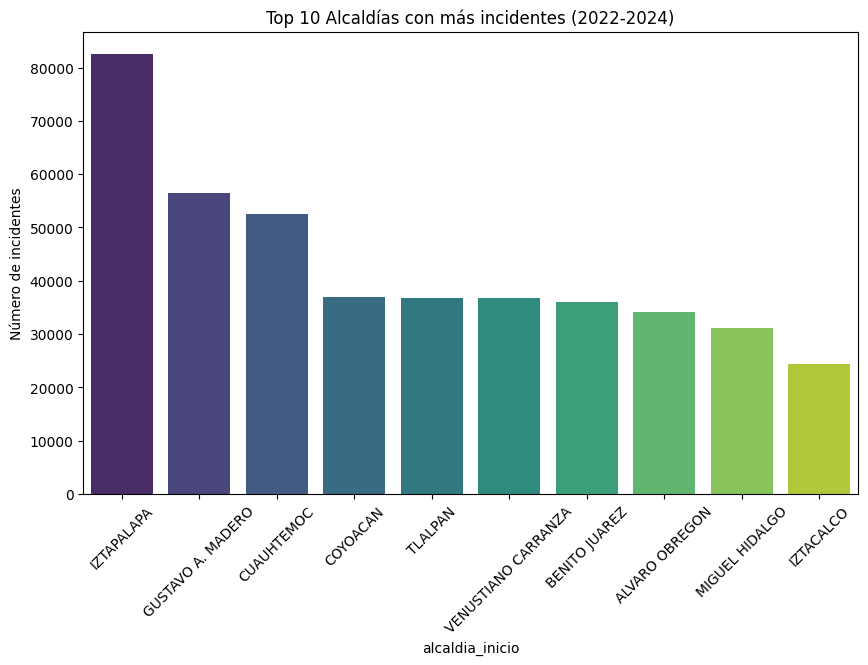

In [56]:
# Configuración general
plt.figure(figsize=(10,6))
sns.barplot(x=acc_por_alcaldia.index[:10], y=acc_por_alcaldia.values[:10], palette="viridis")
plt.title("Top 10 Alcaldías con más incidentes (2022-2024)")
plt.xticks(rotation=45)
plt.ylabel("Número de incidentes")
plt.show()

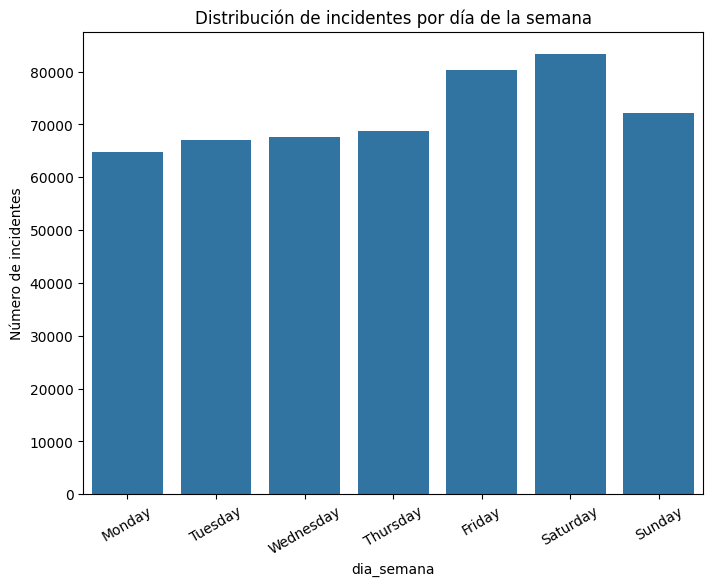

In [58]:
plt.figure(figsize=(8,6))
sns.countplot(x="dia_semana", data=df, order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Distribución de incidentes por día de la semana")
plt.xticks(rotation=30)
plt.ylabel("Número de incidentes")
plt.show()

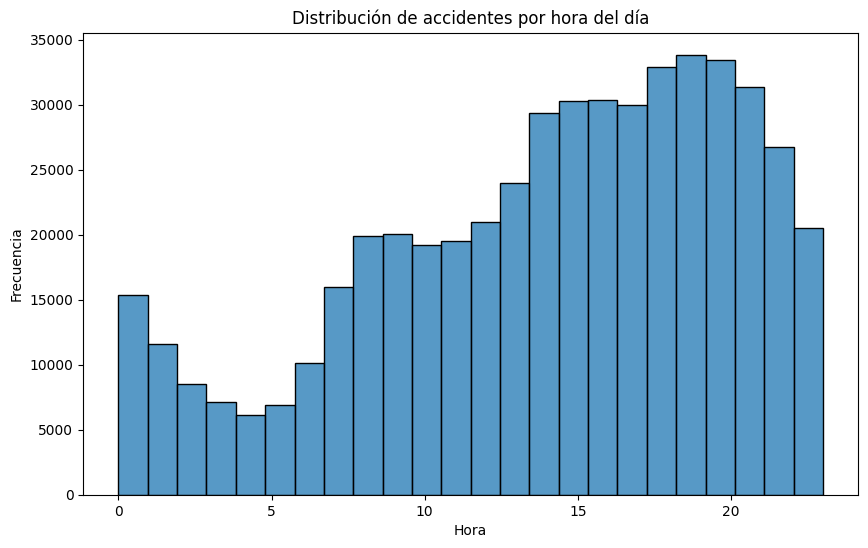

In [59]:
plt.figure(figsize=(10,6))
sns.histplot(df["hora"], bins=24, kde=False)
plt.title("Distribución de accidentes por hora del día")
plt.xlabel("Hora")
plt.ylabel("Número de incidentes")
plt.show()